**Random Forest Modelling**

**Creating and Fitting Baseline Model**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline

import re
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

df = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_full")
X_train = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_train")
X_test = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_test")

In [0]:
# Regression Evaluator
regression_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
regression_evaluator_rmse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="rmse")

# Random forest 

rfc_baseline = RandomForestRegressor(labelCol="log_price", featuresCol="simple_features") # Define the model

# Add to the stages list and create the pipeline object

pipeline_rfc_baseline = Pipeline(stages = [rfc_baseline])

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="log_price", metricName="r2")

paramGrid = ParamGridBuilder() \
    .addGrid(rfc_baseline.maxDepth, [3,5,8]) \
    .addGrid(rfc_baseline.numTrees, [10,20,40]) \
    .build()

crossval = CrossValidator(estimator = pipeline_rfc_baseline,
                         estimatorParamMaps=paramGrid,
                         evaluator = evaluator,
                         numFolds = 5)

cvModel_rfc_baseline = crossval.fit(df)

/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

**Creating and Fitting Text Features Model**

In [0]:
# Random forest 

rfc_text_features = RandomForestRegressor(labelCol="log_price", featuresCol="features") # Define the model

# Add to the stages list and create the pipeline object

pipeline_rfc_text_features = Pipeline(stages = [rfc_text_features])

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="log_price", metricName="r2")

paramGrid = ParamGridBuilder() \
    .addGrid(rfc_text_features.maxDepth, [3,5,8]) \
    .addGrid(rfc_text_features.numTrees, [10,20,40]) \
    .build()

crossval = CrossValidator(estimator = pipeline_rfc_text_features,
                         estimatorParamMaps=paramGrid,
                         evaluator = evaluator,
                         numFolds = 5)

cvModel_rfc_text_features = crossval.fit(df)

**Evaluating the Models**

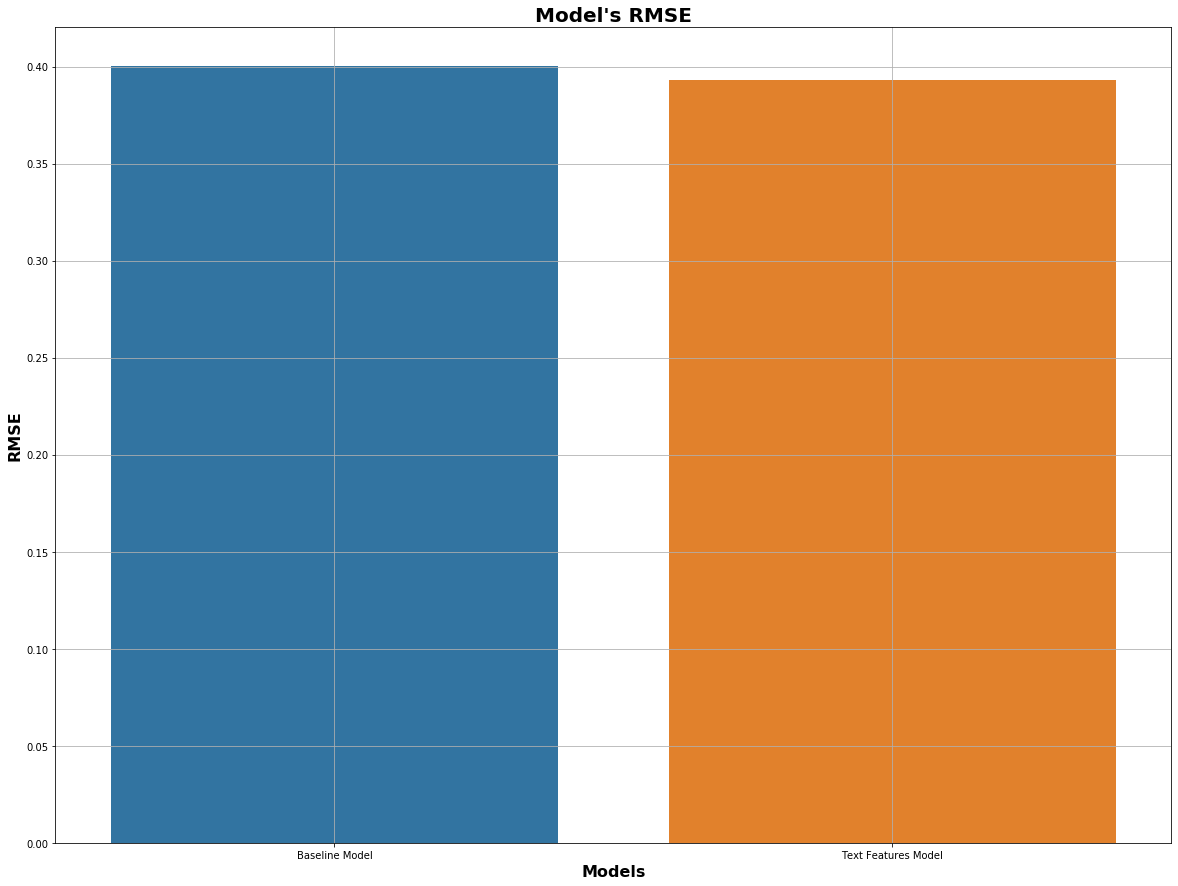

In [0]:
baseline_rmse = regression_evaluator_rmse.evaluate(cvModel_rfc_baseline.transform(X_test))


text_features_rmse = regression_evaluator_rmse.evaluate(cvModel_rfc_text_features.transform(X_test))


rmse = [baseline_rmse, text_features_rmse]
models = ['Baseline Model', 'Text Features Model']

fig, ax = plt.subplots(figsize = (20,15))
res = sns.barplot(models, rmse)
# Plot using seaborn
sns.set(font_scale = 4)
plt.title("Model's RMSE", fontsize = 20, fontweight = 'bold')
plt.xlabel('Models', fontsize = 16, fontweight = 'bold')
plt.ylabel('RMSE', fontsize = 16, fontweight = 'bold')
ax.grid(True)


plt.show()

**Comparing Models and Parameters**

In [0]:
data = {"baseline (r2 score)": cvModel_rfc_baseline.avgMetrics, "text_features (r2 score)":cvModel_rfc_text_features.avgMetrics}
results_df = pd.DataFrame(data=data)
results_df.index = [f"model_{i}" for i in range(9)]
display(results_df)

baseline (r2 score),text_features (r2 score)
0.5188033105999454,0.5194749776111934
0.5195706551161526,0.517507948159052
0.5201589089173667,0.5232124416166679
0.5620417441060518,0.5721937246032165
0.5649583947667233,0.5733930137881565
0.5652452532994845,0.5740054585846722
0.6077995749112104,0.6196674610346197
0.6088485469327727,0.6199182629603502
0.610547449276157,0.6206883090184407


%md

**Model 1**: {

  maxDepth = 3
  
  numTrees = 10
 

}

**Model 2**: {

  maxDepth = 3
  
  numTrees = 20
 

}

**Model 3**: {

  maxDepth = 3
  
  numTrees = 40
 

}

**Model 4**: {

  maxDepth = 5
  
  numTrees = 10
 

}

**Model 5**: {

  maxDepth = 5
  
  numTrees = 20
 

}

**Model 6**: {

  maxDepth = 5
  
  numTrees = 40
 

}

**Model 7**: {

  maxDepth = 8
  
  numTrees = 10
 

}

**Model 8**: {

  maxDepth = 8
  
  numTrees = 20
 

}

**Model 9**: {

  maxDepth = 8
  
  numTrees = 40
 

}

**Visualizing Predictions**

In [0]:
predictions_baseline = cvModel_rfc_baseline.transform(X_test)

# Create a view or table

temp_table_name = "predictions_baseline_csv"

predictions_baseline.createOrReplaceTempView(temp_table_name)

predictions_text_features = cvModel_rfc_text_features.transform(X_test)

# Create a view or table

temp_table_name = "predictions_text_features_csv"

predictions_text_features.createOrReplaceTempView(temp_table_name)

In [0]:
%sql


SELECT log_price AS target, prediction
from predictions_baseline_csv
ORDER BY log_price


target,prediction
2.3978952727983707,4.842634919394032
2.3978952727983707,4.096318150579006
2.3978952727983707,4.622380612823326
2.3978952727983707,4.068435672837218
2.3978952727983707,4.237708460715878
2.639057329615259,3.680606055589524
2.772588722239781,3.5424528227753767
2.772588722239781,5.513148592208181
2.833213344056216,5.023599360930381
3.044522437723423,3.95608107779022


In [0]:
%sql


SELECT log_price AS target, prediction
from predictions_text_features_csv
ORDER BY log_price


target,prediction
2.3978952727983707,4.881974726431845
2.3978952727983707,3.9033715495105894
2.3978952727983707,4.423272082935118
2.3978952727983707,4.054653550572884
2.3978952727983707,4.197818149040369
2.639057329615259,3.777230225088354
2.772588722239781,3.4257080506773057
2.772588722239781,5.46912096085053
2.833213344056216,5.006955494570046
3.044522437723423,3.9252578359776544
